In [27]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [28]:
dia = pd.read_csv("C:/Users/Iris/OneDrive/Desktop/Data/datasets/dia2.csv")
dia

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [29]:
# Upon checking, there seems to be some repeated diamonds. We clean up this dataset below (note, originally, there are over 50,000 entries)

In [30]:
check = ["carat", "cut", "color", "clarity", "price"]
dia_unique = dia.drop_duplicates(subset = check)

print(f"Unique diamonds: {len(dia_unique)}")

Unique diamonds: 39756


In [31]:
# Goal 1: Plot carat against price, and color code the scatter plot points by the cut of the diamond 

In [32]:
cut_codes = dia_unique['cut'].astype('category').cat.codes
cut_labels = dia_unique['cut'].astype('category').cat.categories

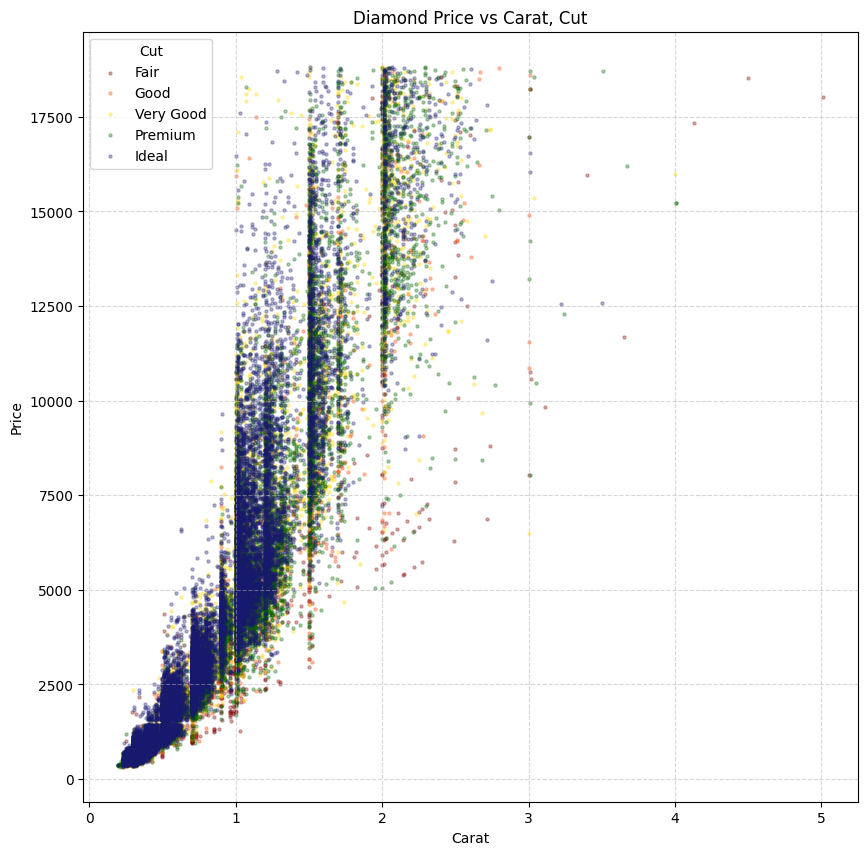

In [33]:
colors = {
    "Fair": "#800000",
    "Good": "#ff4500",
    "Very Good": "#ffd700", 
    "Premium": "#006400", 
    "Ideal": "#191970" 
}

plt.figure(figsize=(10,10))

for cut_value, col in colors.items():
    subset = dia_unique[dia_unique['cut'] == cut_value]
    plt.scatter(
        subset["carat"], subset["price"],
        label = cut_value, c = col, alpha = 0.3, s = 5
    )

plt.xlabel('Carat')
plt.ylabel('Price')
plt.title('Diamond Price vs Carat, Cut')
plt.legend(title="Cut")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [34]:
# The above graph is "functional", but since the dataset is so large, it remains somewhat dense and unclear. Below, I'll create an averages trend plot for readability.

Text(0.5, 1.0, 'Average Diamond Price by Carat and Cut')

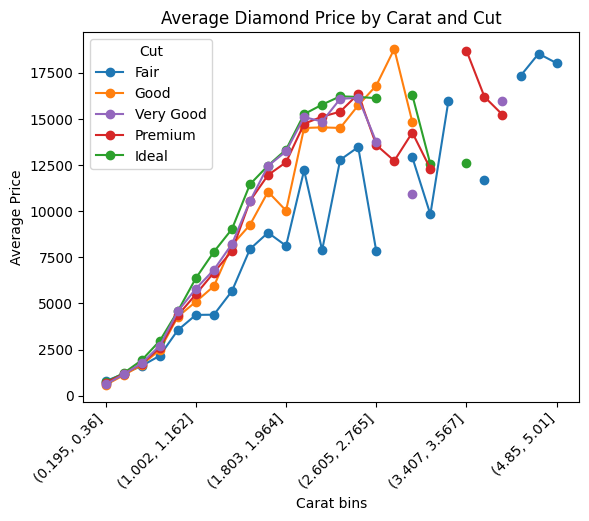

In [35]:
binned = dia_unique.groupby([pd.cut(dia_unique["carat"], 30), "cut"], observed=True)["price"].mean().unstack()
binned.plot(kind="line", marker="o")

handles, labels = plt.gca().get_legend_handles_labels()
order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]

handles = [handles[labels.index(cat)] for cat in order]
labels = order

plt.legend(handles, labels, title="Cut")

plt.ylabel("Average Price")
plt.xlabel("Carat bins")
plt.xticks(rotation=45, ha="right")
plt.title("Average Diamond Price by Carat and Cut")

In [ ]:
# Above, we can see that as we compare carat weight to average price while filtering for the cut of the diamond, we have a somewhat consistent linear pattern 
# showing us that cut is an okay predictor for price of a diamond, but still somewhat erratic. 
# Below, we'll investigate other, possibly clearer predictors for the price of a diamond based on carat weight. 

In [ ]:
# Goal 2: Plot carat against price, and color code the scatter plot points by the clarity of the diamond.

In [37]:
clarity_codes = dia_unique['clarity'].astype('category').cat.codes
clarity_labels = dia_unique['clarity'].astype('category').cat.categories

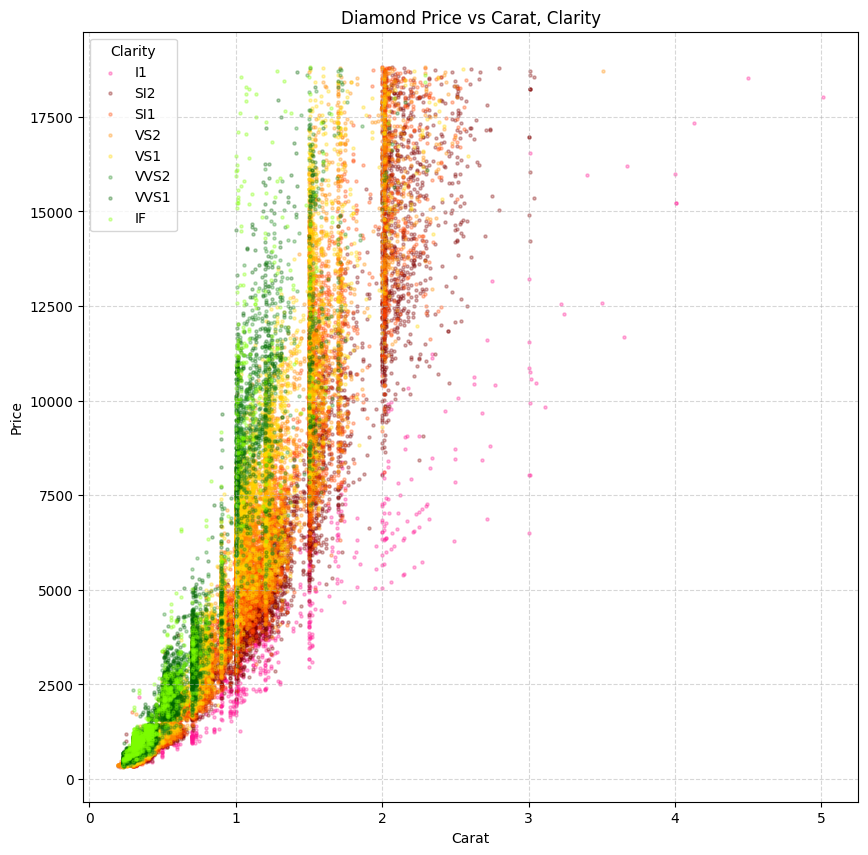

In [48]:
colors = {
    "I1": "#ff1493",
    "SI2": "#800000",
    "SI1": "#ff4500",
    "VS2": "#ff8c00",
    "VS1": "#ffd700", 
    "VVS2":"#228b22",
    "VVS1":"#006400",
    "IF": "#7fff00",
}

plt.figure(figsize=(10,10))

for clarity_value, col in colors.items():
    subset = dia_unique[dia_unique['clarity'] == clarity_value]
    plt.scatter(
        subset["carat"], subset["price"],
        label = clarity_value, c = col, alpha = 0.3, s = 5
    )

plt.xlabel('Carat')
plt.ylabel('Price')
plt.title('Diamond Price vs Carat, Clarity')
plt.legend(title="Clarity")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
# Once again, the above graph is functional, but still remains somewhat dense and unclear. Below, I'll create an averages trend plot for further readability.
#
# It should be important to note that though the colors are different due to increased number of variables, that this plot also maintains a similar linear pattern as above.

Text(0.5, 1.0, 'Average Diamond Price by Carat and Clarity')

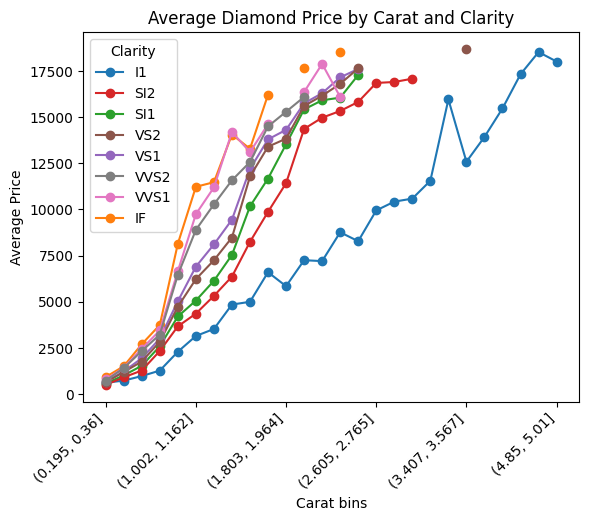

In [ ]:
binned = dia_unique.groupby([pd.cut(dia_unique["carat"], 30), "clarity"], observed=True)["price"].mean().unstack()
binned.plot(kind="line", marker="o")

handles, labels = plt.gca().get_legend_handles_labels()
order = ["I1","SI2", "SI1","VS2","VS1","VVS2","VVS1","IF"]

handles = [handles[labels.index(cat)] for cat in order]
labels = order

plt.legend(handles, labels, title="Clarity")

plt.ylabel("Average Price")
plt.xlabel("Carat bins")
plt.xticks(rotation=45, ha="right")
plt.title("Average Diamond Price by Carat and Clarity")

In [ ]:
# In the above graph, we can clearly see a stronger, more consistent linear pattern, indicating that the combination of carat size and clarity grading provides useful
# information in predicting average price of a diamond. 
# You can see, quite neatly, that as clarity goes down, prices drop on average, and that for each clarity grade
# as carat weight goes up, the price maintains a consistent increase as well. 
# Finally, we observe that as the quality of the diamond gets better, the increase in price by carat becomes steeper, indicating that clarity is a significant factor in price. 